<a href="https://colab.research.google.com/github/JP2821/NaiveBayeSUS/blob/main/NaiveBayeSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dicionarios de dados:
https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/pdfs/dicionario_de_dados_srag_hosp_17_02_2022.pdf

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def grafico_barra(serie,title=None,ylabel=None,xlabel=None,legend = None,color='b', show = True):
    plt.figure(figsize=(20, 4)) 
    plt.bar(np.arange(0,serie.size), serie, color = color,
            label=legend)

    if title : plt.title( title)
    if ylabel: plt.ylabel(ylabel)
    if xlabel: plt.xlabel(xlabel)
    if legend: plt.legend()
    if show: plt.show()

In [4]:
def print_range(df):
    print(pd.to_datetime(df["DT_NOTIFIC"]).min(), pd.to_datetime(df["DT_NOTIFIC"]).max())

# Unir bases de dados

Colunas selecionadas:

* 1 - Idade 
* 2 - Fatores de risco 
* 3 - Fatores de risco/ Doença Cardiovascular Crônica
* 4 - Fatores de risco/ Asma
* 5 - Pneumatopatia Crônica
* 6 - Fatores de risco/ Diabetes mellitus
* 7 - Fatores de risco/ Imunodeficiência ou Imunodepressão
* 8 - Fatores de risco/ Obesidade 
* 9 - Fatores de risco/ Obesidade(Descrição IMC)
* 10 - Recebeu a vacina COVID-19?
* 11 - Recebeu vacina contra Gripe na última campanha?
* 12 - Houve internação? 
* 13 - colunas com as datas referentes a cada um dos eventos  temporais 
* 14 - Internado em UTI? 
* 15 - Uso de suporte ventilatório?
* 16 - Agente etiológico – Teste Antigênico.
* 17 - SARS-CoV-2
* 18 - Aspecto Tomografia
* 19 - Resultado da RT-PCR/outro método por Biologia Molecular
* 20 - Agente etiológico – RT-PCR/outro método por Biologia Molecular: SARS-CoV-2 
* 21 - Agente etiológico – Teste Antigênico. Positivo para Influenza? 
* 22 - Resultado do Teste Antigênico
* 23 - Resultado do Teste Sorológico para SARS-CoV-2: IgG
* 24 - Resultado do Teste Sorológico para SARS-CoV-2: IgM 
* 25 - Resultado do Teste Sorológico para SARS-CoV-2: IgA 
* 26-   data primeiros sintomas


In [5]:
colunas_selecionadas = [
    "NU_IDADE_N",
    "FATOR_RISC",
    "CARDIOPATI",
    "ASMA",
    "PNEUMOPATI",
    "DIABETES",
    "IMUNODEPRE",
    "OBESIDADE",
    "OBES_IMC",
    "VACINA_COV",
    "VACINA",
    "HOSPITAL",
    "DT_SIN_PRI",
    "DT_NOTIFIC",
    "DT_NASC",
    "DOSE_1_COV",
    "DOSE_2_COV" ,
    "DOSE_REF",
    "DT_UT_DOSE",
    "DT_INTERNA",
    "DT_ENTUTI",
    "DT_SAIDUTI",
    "DT_EVOLUCA",
    "DT_DIGITA",
    "UTI",
    "EVOLUCAO",
    "TOMO_RES",
    "RES_AN",
    "PCR_RESUL",
    "PCR_SARS2",
    "POS_AN_FLU",
    "RES_IGG",
    "RES_IGM",
    "RES_IGA",
    "SEM_NOT", #Semana Epidemiológica do preenchimento da ficha de notificação
    "SEM_PRI",  #Semana Epidemiológica dos Primeiros Sintomas
    # "FAB_COV1",
    # "FAB_COV2",

]

## Compatibilidade entre as bases


Podemos ver que a base de dados de 2020 não possui todas as colunas que as outras. Em especial , as colunas selecionadas: 'VACINA_COV' (se o paciente recebeu a vacina do covid), 'DOSE_1_COV' (data em que recebeu a 1° dose), 'DOSE_2_COV' (data em que recebeu a 2° dose), 'DOSE_REF' (data em que recebeu a dose de reforço).

As datas referentes a vacina na base de 2020 não informam claramente se é para gripe ou covid.

Pela data, sabemos que a maioria das pessoas não tomou a vacina. Cerca de 4% da base de dados de 2020 (estranhamente) está depois de 17/01/2021 (início da vacinação do brasil). Portanto, não teremos problemas em considerar que ninguem foi vacinado nesta base.

In [6]:
df20 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2020.csv',error_bad_lines=False,sep = ';')
print("\ninformações")
df20.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,91,93,105,114,116,117,118,122) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



informações
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199992 entries, 0 to 1199991
Columns: 153 entries, DT_NOTIFIC to RES_IGA
dtypes: float64(87), int64(9), object(57)
memory usage: 1.4+ GB


In [7]:
for col_escolhida in ['VACINA_COV' , 'DOSE_1_COV' , 'DOSE_2_COV' , 'DOSE_REF', "FAB_COV1","FAB_COV2"]:
    print(col_escolhida,end = " ")
    if col_escolhida in df20.columns: print("está na base de 2020")
    else:
        print("não está na base de 2020")
        df20[col_escolhida] = np.NaN

VACINA_COV não está na base de 2020
DOSE_1_COV não está na base de 2020
DOSE_2_COV não está na base de 2020
DOSE_REF não está na base de 2020
FAB_COV1 não está na base de 2020
FAB_COV2 não está na base de 2020


In [8]:
print("primeira e última datas:")
print_range(df20)
print("\npessoas que notificaram depois de 17/01/2021:",end=" ")
print(df20[pd.to_datetime(df20["DT_NOTIFIC"]) > pd.to_datetime("2021-01-17 00:00:00")].shape[0])
print("tamanho total da base: ", df20.shape[0])

primeira e última datas:
2019-12-29 00:00:00 2022-12-03 00:00:00

pessoas que notificaram depois de 17/01/2021: 49796
tamanho total da base:  1199992


In [9]:
df20 = df20[colunas_selecionadas]

## Unir as bases

In [10]:
df21 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2021.csv',error_bad_lines=False,sep = ';')
print("-"*100)
print("df21")
print_range(df21)
df21 = df21[colunas_selecionadas]
df = df20.append(df21, ignore_index=True)

# liberar memória
del df20
del df21

print("-"*100)


df22 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2022.csv',error_bad_lines=False,sep = ';')
print("-"*100)
print("df22")
print_range(df22)
df22 = df22[colunas_selecionadas]



df = df  .append(df22,ignore_index = True)
print("-"*100)

del df22

print("df")
print_range(df)

print("-"*100)
print(df.info())
df.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,114,116,117,118,122,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


----------------------------------------------------------------------------------------------------
df21
2021-01-02 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,66,91,93,107,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


----------------------------------------------------------------------------------------------------
df22
2022-01-02 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------
df
2019-12-29 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107773 entries, 0 to 3107772
Data columns (total 36 columns):
 #   Column      Dtype  
---  ------      -----  
 0   NU_IDADE_N  int64  
 1   FATOR_RISC  object 
 2   CARDIOPATI  float64
 3   ASMA        float64
 4   PNEUMOPATI  float64
 5   DIABETES    float64
 6   IMUNODEPRE  float64
 7   OBESIDADE   float64
 8   OBES_IMC    object 
 9   VACINA_COV  float64
 10  VACINA      float64
 11  HOSPITAL    float64
 12  DT_SIN_PRI  object 
 13  DT_NOTIFIC  object 
 14  DT_NASC     object 
 15  DOSE_1_COV  object 
 16  DOSE_2_COV  object 
 17  DOSE_REF    obje

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
0,7,S,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2,2
1,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,57,S,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,7,6
3,9,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5,5
4,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,3,2


# Eliminando casos com datas de notificações no futuro (hoje em dia 24/03/2022)

#### Para realizar comparações temporais entre datas sreá necessário fazer o casting das colunas para datetime, caso contrário, a comparação se dará pela ordem alfabética nas quais os números aparecem.


Não há nenhuma linha com data de notificação NaN:

In [11]:
df["DT_NOTIFIC"][pd.isnull(df["DT_NOTIFIC"]) == True]

Series([], Name: DT_NOTIFIC, dtype: object)

In [12]:
def convert_to_date(texto):
    try:
        return pd.to_datetime(texto)   

    except:
        print(texto)
        return np.NaN
        

In [13]:
#print('DOSE_1_COV:')
#df['DOSE_1_COV'][pd.isnull(df['DOSE_1_COV']) ==False]  = df['DOSE_1_COV'][pd.isnull(df['DOSE_1_COV']) ==False].apply(convert_to_date)
#
#print("DOSE_2_COV:")
#df["DOSE_2_COV"][pd.isnull(df["DOSE_2_COV"]) ==False] = df["DOSE_2_COV"][pd.isnull(df["DOSE_2_COV"]) ==False].apply(convert_to_date)
#
#print('DT_ENTUTI:')
#df['DT_ENTUTI'][pd.isnull(df['DT_ENTUTI']) ==False]   = df['DT_ENTUTI'][pd.isnull(df['DT_ENTUTI']) ==False].apply(convert_to_date)
#
#print('DT_INTERNA:')
#df['DT_INTERNA'][pd.isnull(df['DT_INTERNA']) ==False] = df['DT_INTERNA'][pd.isnull(df['DT_INTERNA']) ==False].apply(convert_to_date)

In [14]:
df['DT_UT_DOSE'] = pd.to_datetime(df['DT_UT_DOSE']   )
df['DT_NASC']    = pd.to_datetime(df['DT_NASC']   )
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'])	
df['DT_SAIDUTI'] = pd.to_datetime(df['DT_SAIDUTI'])
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'])
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'])

# **Vê se não temos super humanos entre nos**

Removeremos 131 registros de pessoas com mais de 100 anos ou menos de 2 anos,pois são pessoas que conseguiram viajar no tempo e nasceram antes de nascerem

In [15]:
print('IDADE:')
df[~df["NU_IDADE_N"].between(0,110)]["NU_IDADE_N"]

IDADE:


15221      138
39156      120
42546      136
68851      113
83111      112
          ... 
3022920    115
3052634    117
3064695    114
3082522    116
3085871    113
Name: NU_IDADE_N, Length: 131, dtype: int64

In [16]:
indices = df.index[~df["NU_IDADE_N"].between(0,110) ]
df.drop(index = indices, inplace = True)
print('IDADE:')
df[~df["NU_IDADE_N"].between(0,110)]["NU_IDADE_N"]

IDADE:


Series([], Name: NU_IDADE_N, dtype: int64)

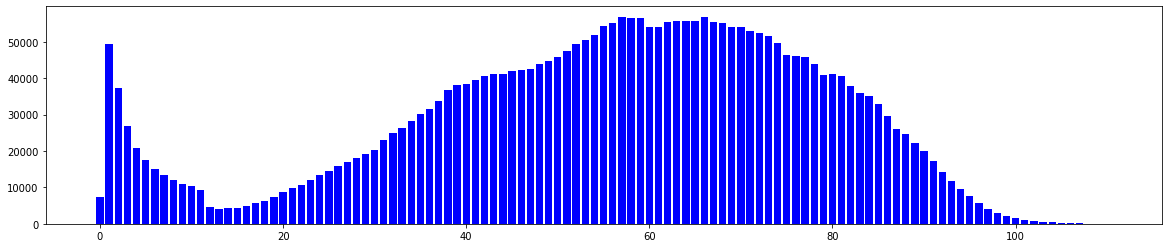

,num_pessoas
NU_IDADE_N,
0,7312
1,49533
2,37221
3,26952
4,20914
...,...
106,140
107,107
108,70


In [17]:
Npessoas_idade = df[["NU_IDADE_N","DT_NOTIFIC"]].groupby(by="NU_IDADE_N").count() 
Npessoas_idade = Npessoas_idade.rename(columns={"DT_NOTIFIC": "num_pessoas"})["num_pessoas"].to_frame() 
grafico_barra(Npessoas_idade.num_pessoas)
Npessoas_idade

In [18]:
ordenado = df[["NU_IDADE_N","DT_NOTIFIC"]].sort_values(by="NU_IDADE_N")
ordenado

,NU_IDADE_N,DT_NOTIFIC
1434340,0,2021-04-15
845760,0,2020-06-25
1177699,0,2020-05-08
845754,0,2020-04-05
1620136,0,2021-11-09
...,...,...
1214418,110,2021-02-13
883870,110,2020-07-17
583349,110,2020-12-05
1050413,110,2020-08-04


# **Checando se existem datas na Coluna UTI fora do padrão**

In [64]:
print("Casos sem status na UTI:")
df[~df['UTI'].between(1,10)]['UTI'] 

Casos sem status na UTI:


5         NaN
7         NaN
12        NaN
22        NaN
23        NaN
           ..
3107758   NaN
3107759   NaN
3107763   NaN
3107765   NaN
3107770   NaN
Name: UTI, Length: 438871, dtype: float64

In [20]:
print("Casos sem entrada na UTI:")
df[df['UTI'] == 2]['UTI']

Casos sem entrada na UTI:


0          2.0
1          2.0
3          2.0
4          2.0
6          2.0
          ... 
3107762    2.0
3107766    2.0
3107768    2.0
3107771    2.0
3107772    2.0
Name: UTI, Length: 1706280, dtype: float64

In [21]:
print("Casos com entrada na UTI:")
df[df['UTI'] == 1]['UTI']

Casos com entrada na UTI:


2          1.0
9          1.0
11         1.0
14         1.0
20         1.0
          ... 
3107753    1.0
3107756    1.0
3107764    1.0
3107767    1.0
3107769    1.0
Name: UTI, Length: 899017, dtype: float64

In [22]:
print("Casos Ignorados:")
df[df['UTI']== 9]['UTI']

Casos Ignorados:


70         9.0
81         9.0
107        9.0
170        9.0
275        9.0
          ... 
3107502    9.0
3107551    9.0
3107576    9.0
3107602    9.0
3107650    9.0
Name: UTI, Length: 63341, dtype: float64

# verificando casos de uti pediatrica imediatamente ao nascer

In [23]:
verificando = (df['DT_NASC'] == df['DT_ENTUTI']) 
verificando                                      
                                                

0          False
1          False
2          False
3          False
4          False
           ...  
3107768    False
3107769    False
3107770    False
3107771    False
3107772    False
Length: 3107642, dtype: bool

In [24]:
verificando = df.index[(df['DT_NASC'] == df['DT_ENTUTI'])]
print(f'N° de bebes que ao nascer foram internados na uti: {len(verificando)}')
df.drop(index = verificando, inplace = True)

N° de bebes que ao nascer foram internados na uti: 0


In [25]:
verificando2 = (df['DT_ENTUTI'] == df['DT_INTERNA'])
verificando2

0          False
1          False
2           True
3          False
4          False
           ...  
3107768    False
3107769     True
3107770    False
3107771    False
3107772    False
Length: 3107642, dtype: bool

In [26]:
#Eliminando as datas de entrada e saída igual
verificando2 = df.index[(df['DT_ENTUTI'] == df['DT_INTERNA'])]
print(f'Rodrigato:{len(verificando2)}')
df.drop(index = verificando2, inplace = True)

Rodrigato:607068


Também foi verificado que durante o decorrer dos anos de 2021 e 2022 foram encotrados (**690**) casos de pessoas que tomaram ambas as doses em simultâneo 

In [27]:
verificando3 = (df['DOSE_1_COV'] == df['DOSE_2_COV']) # Antes do filtro 2.500.575
verificando3                                          # Depois do filtro 2.499.885

0          False
1          False
3          False
4          False
5          False
           ...  
3107766    False
3107768    False
3107770    False
3107771    False
3107772    False
Length: 2500574, dtype: bool

**vacina da  jansen é dose unica**

In [28]:
#Eliminando doses em um dia
verificando3 = df.index[(df['DOSE_1_COV'] == df['DOSE_2_COV'])]
print(f'Rodrigato:{len(verificando3)}')
df.drop(index = verificando3, inplace = True)

Rodrigato:690


# **Verificando a existência de dados vagos dentro da coluna de semanas epidemiológicas**

In [29]:
df[~df['SEM_NOT'].between(0,53)]['SEM_NOT']  # Por que 53 ?
                                             # Um ano tem 52 semanas, 
                                             #levando em consideração que começam da semana 1 e não zero por isso 53 

Series([], Name: SEM_NOT, dtype: int64)

In [30]:
df[~df['SEM_PRI'].between(0,53)]['SEM_PRI'] 


Series([], Name: SEM_PRI, dtype: int64)

In [31]:
df['DT_NASC'].dt.year

0          2019.0
1          2018.0
3          2019.0
4          2018.0
5          1991.0
            ...  
3107766    2020.0
3107768    1980.0
3107770    1932.0
3107771    1940.0
3107772    1970.0
Name: DT_NASC, Length: 2499884, dtype: float64

In [32]:
for col in df.columns:
    print(col)

NU_IDADE_N
FATOR_RISC
CARDIOPATI
ASMA
PNEUMOPATI
DIABETES
IMUNODEPRE
OBESIDADE
OBES_IMC
VACINA_COV
VACINA
HOSPITAL
DT_SIN_PRI
DT_NOTIFIC
DT_NASC
DOSE_1_COV
DOSE_2_COV
DOSE_REF
DT_UT_DOSE
DT_INTERNA
DT_ENTUTI
DT_SAIDUTI
DT_EVOLUCA
DT_DIGITA
UTI
EVOLUCAO
TOMO_RES
RES_AN
PCR_RESUL
PCR_SARS2
POS_AN_FLU
RES_IGG
RES_IGM
RES_IGA
SEM_NOT
SEM_PRI


# Fatores de risco

In [33]:
lista_fatores = [
    "FATOR_RISC",
"CARDIOPATI",
"ASMA",
"PNEUMOPATI",
"DIABETES",
"IMUNODEPRE",
"OBESIDADE",]

A maioria dos casos de obesidade nao possui IMC registrada. Infelizmente, temos casos de obesidade sem sentido (com IMC muito pequeno). Por isso vamos apenas considerar obesidades registradas como morbida ($IMC \ge 40$ )

In [34]:
df_obesos_por_IMC = df[["OBES_IMC","DT_NOTIFIC","NU_IDADE_N"]].groupby(by = ["OBES_IMC","NU_IDADE_N"]).count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()


In [35]:
df_obesos_por_IMC

N_pessoas
OBES_IMC NU_IDADE_N           
0        1                   2
         2                   1
         3                   1
         4                   1
         7                   2
...                        ...
99,9     88                  2
         89                  2
         91                  2
         92                  1
         94                  1

[10093 rows x 1 columns]

In [36]:
df[df["OBESIDADE"] == 1][pd.isnull(df["OBES_IMC"])== False][["OBES_IMC","OBESIDADE","NU_IDADE_N"] ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OBES_IMC,OBESIDADE,NU_IDADE_N
89,"37,2",1.0,44
119,"49,8",1.0,33
136,"4,1",1.0,55
146,"5,6",1.0,60
180,40,1.0,41
...,...,...,...
3107314,0,1.0,57
3107402,40,1.0,80
3107409,1,1.0,73
3107482,"29,4",1.0,77


Conversao dos valores de obesidade

In [37]:
def conversion(numero_str):
    f = None
    try:
        f= float(numero_str.replace(',','.'))
    except:
        1+1
        #print(numero_str,type(numero_str))
    return f

In [38]:
lista_IMC = df.OBES_IMC.drop_duplicates().apply(conversion).sort_values().tolist()
print()
lista_IMC

[0.0,
 0.03,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3.0,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5.0,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.1,
 6.3,
 6.4,
 6.5,
 6.6,
 7.1,
 8.3,
 8.8,
 8.9,
 9.0,
 9.9,
 10.0,
 10.3,
 10.5,
 10.8,
 11.0,
 11.1,
 11.2,
 11.3,
 11.5,
 11.6,
 12.0,
 12.2,
 12.3,
 12.5,
 13.0,
 13.3,
 13.4,
 13.5,
 13.6,
 14.0,
 14.2,
 14.4,
 15.0,
 15.5,
 15.6,
 15.7,
 16.0,
 16.1,
 16.3,
 16.4,
 16.5,
 16.8,
 16.9,
 17.0,
 17.4,
 17.7,
 18.0,
 18.6,
 18.9,
 19.0,
 19.5,
 19.7,
 19.9,
 20.0,
 20.1,
 20.2,
 20.5,
 20.6,
 20.8,
 20.9,
 21.0,
 21.2,
 21.3,
 21.7,
 21.8,
 22.0,
 22.2,
 22.3,
 22.4,
 22.5,
 22.6,
 22.7,
 22.8,
 22.9,
 23.0,
 23.1,
 23.2,
 23.3,
 23.4,
 23.5,
 23.6,
 23.7,
 23.8,
 23.9,
 24.0,
 24.1,
 24.2,
 24.3,
 24.4,
 24.5,
 24.6,
 24.7,
 24.8

In [39]:
df["OBES_IMC"] = df["OBES_IMC"].apply(conversion)


df[df["OBESIDADE"] == 1][pd.isnull(df["OBES_IMC"])== False][["OBES_IMC","OBESIDADE"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,OBES_IMC,OBESIDADE
89,37.2,1.0
119,49.8,1.0
136,4.1,1.0
146,5.6,1.0
180,40.0,1.0
...,...,...
3107314,0.0,1.0
3107402,40.0,1.0
3107409,1.0,1.0
3107482,29.4,1.0


In [40]:
df_morbidos = df[["OBES_IMC","NU_IDADE_N","DT_NOTIFIC"]][df["OBES_IMC"] >=40.0]
df_morbidos

,OBES_IMC,NU_IDADE_N,DT_NOTIFIC
119,49.8,33,2020-01-04
180,40.0,41,2020-09-04
362,42.4,28,2020-07-05
376,99.9,61,2020-04-05
572,42.7,55,2020-04-05
...,...,...,...
3088705,40.0,78,2022-02-02
3094574,70.0,51,2022-06-01
3097534,48.3,39,2022-02-27
3102800,43.7,18,2022-02-16


In [41]:
pd.isnull(False)

False

In [42]:
df[(pd.isnull(df["OBES_IMC"])  | pd.isnull(df["OBESIDADE"])) & (df["OBESIDADE"] != False) & (df["OBES_IMC"] != False)]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
0,7,S,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2,2
1,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
3,9,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5,5
4,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,3,2
5,28,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,4.0,2.0,NaN,NaN,4.0,4.0,4.0,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107766,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,6.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,11,10
3107768,41,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,9.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,6,6
3107770,89,1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,...,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,8,7
3107771,81,1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,...,6.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,7,6


In [43]:
indices_nao_especificados = df[(pd.isnull(df["OBES_IMC"])  | pd.isnull(df["OBESIDADE"])) & (df["OBESIDADE"] != False) & (df["OBES_IMC"] != False)].index
indices_nao_especificados

Int64Index([      0,       1,       3,       4,       5,       6,       7,
                  8,       9,      10,
            ...
            3107760, 3107761, 3107762, 3107763, 3107765, 3107766, 3107768,
            3107770, 3107771, 3107772],
           dtype='int64', length=2464897)

In [44]:
# se df.OBES_IMC is np.NaN ---> 9.0, 
# pois (np.NaN comparador outra_coisa) == False
# para ver isto, rode: np.NaN < 10
df.OBESIDADE = ( 1.0*(df.OBES_IMC >= 40.0)  + 2.0*(df.OBES_IMC < 40.0)  ) + 9.0*(pd.isnull(df.OBES_IMC))
df[df["OBESIDADE"] == 1.0]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
119,33,S,NaN,NaN,NaN,NaN,NaN,1.0,49.8,NaN,...,NaN,5.0,1.0,1.0,NaN,NaN,NaN,NaN,14,14
180,41,S,1.0,2.0,2.0,2.0,2.0,1.0,40.0,NaN,...,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,15,14
362,28,S,1.0,1.0,2.0,2.0,2.0,1.0,42.4,NaN,...,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,19,17
376,61,S,1.0,NaN,NaN,1.0,NaN,1.0,99.9,NaN,...,NaN,5.0,1.0,1.0,NaN,NaN,NaN,NaN,19,18
572,55,S,1.0,2.0,2.0,2.0,2.0,1.0,42.7,NaN,...,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,19,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088705,78,1,1.0,2.0,2.0,2.0,2.0,1.0,40.0,2.0,...,1.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,5,5
3094574,51,1,2.0,1.0,2.0,2.0,2.0,1.0,70.0,1.0,...,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1,1
3097534,39,1,1.0,NaN,1.0,1.0,NaN,1.0,48.3,1.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,7
3102800,18,1,NaN,NaN,NaN,NaN,NaN,1.0,43.7,2.0,...,6.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,7,5


ValueError: ignored

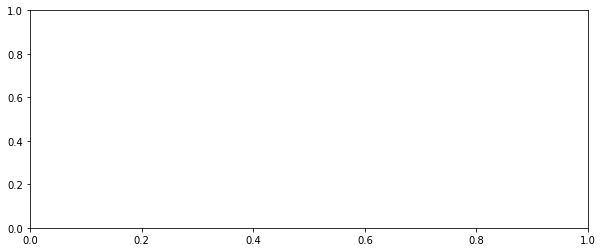

In [47]:

plt.figure(figsize=(10, 4)) 
plt.bar(df.OBES_IMC.drop_duplicates().sort_values(), df_obesos_por_IMC.N_pessoas, color = 'b', label='risco',width=0.4)
plt.title("N° mortos")
plt.legend()
plt.show()

In [48]:
df[df["FATOR_RISC"] == 2][["NU_IDADE_N",	"FATOR_RISC"]]

,NU_IDADE_N,FATOR_RISC
1199993,19,2
1199995,36,2
1199998,78,2
1200002,64,2
1200003,36,2
...,...,...
3107750,66,2
3107753,27,2
3107758,34,2
3107766,1,2


# Fator de risco

não há casos de fator de risco não preenchido

In [49]:
df[pd.isnull(df["FATOR_RISC"])]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI


## S e N, não descritos no dicionário de dados

Não sabemos o que seria S, provavelmente Sim

In [50]:
df[df["FATOR_RISC"] == 'S']

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
0,7,S,NaN,NaN,1.0,NaN,1.0,9.0,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2,2
8,55,S,2.0,2.0,2.0,2.0,2.0,9.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,11,9
10,83,S,1.0,2.0,2.0,2.0,2.0,9.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,12,12
12,57,S,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,13,13
19,67,S,2.0,1.0,2.0,1.0,2.0,9.0,NaN,NaN,...,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199982,82,S,2.0,2.0,2.0,1.0,2.0,9.0,NaN,NaN,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,45,44
1199983,83,S,2.0,2.0,2.0,1.0,2.0,9.0,NaN,NaN,...,2.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,1,51
1199986,81,S,1.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,40,40
1199987,60,S,NaN,NaN,NaN,1.0,NaN,9.0,NaN,NaN,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,33,31


O mesmo para N, provavelmente "não"

In [51]:
df[df["FATOR_RISC"] == 'N']

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
1,1,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
3,9,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5,5
4,1,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,3,2
5,28,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,6.0,4.0,2.0,NaN,NaN,4.0,4.0,4.0,9,9
6,29,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199975,67,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,1,53
1199980,85,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,5,53
1199985,75,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,50,50
1199988,54,N,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,49


## Limpeza/padronização dos dados das colunas de comorbidades selecionadas

Não há nenhum dado que não seja NaN, 1.0, 2.0 , ou 9.0 .

Faremos o casting de NaN para 9.0 (ignorado)

In [52]:
for col in lista_fatores[1:-1]:
    print(df[(df[col] != 1.0) & (df[col] != 2.0) & (df[col] != 9.0) &  ( pd.isnull(df[col] ) == False )][col])

Series([], Name: CARDIOPATI, dtype: float64)
Series([], Name: ASMA, dtype: float64)
Series([], Name: PNEUMOPATI, dtype: float64)
Series([], Name: DIABETES, dtype: float64)
Series([], Name: IMUNODEPRE, dtype: float64)


In [53]:
for col in lista_fatores[1:-1]:
    df[col] = 9.0*( (pd.isnull(df[col])) | (df[col] == 0.0)) + 1.0*(df[col] == 1.0) + 2.0*(df[col] == 2.0)  

df[lista_fatores[1:-1]]

,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE
0,9.0,9.0,1.0,9.0,1.0
1,9.0,9.0,9.0,9.0,9.0
3,9.0,9.0,9.0,9.0,9.0
4,9.0,9.0,9.0,9.0,9.0
5,9.0,9.0,9.0,9.0,9.0
...,...,...,...,...,...
3107766,9.0,9.0,9.0,9.0,9.0
3107768,9.0,9.0,9.0,9.0,9.0
3107770,1.0,2.0,2.0,2.0,2.0
3107771,1.0,2.0,2.0,2.0,2.0


## atribuição dos fatores de riscos que selecionamos

In [54]:
df.FATOR_RISC = 1.0*( 
    (df[lista_fatores[1:]] == 1).any("columns") # se alguma coluna tiver comorbidade, fator_risc = 1 (com comorbidade)
    ) + 2.0*( 
            (df[lista_fatores[1:]]== 2).all("columns") # se todas colunas nao tiverem comorbidade, fator_risc = 2 (sem comorbidade)
            ) + 9.0*(
                    (df[lista_fatores[1:]] != 1 ).all("columns") & (df[lista_fatores[1:]] != 2).any("columns") # se nenhuma comorbidade, mas há uma comorbidade ignorada, fator_risc = 9 (ignorado)
                    )
df[lista_fatores]

,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE
0,1.0,9.0,9.0,1.0,9.0,1.0,9.0
1,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3,9.0,9.0,9.0,9.0,9.0,9.0,9.0
4,9.0,9.0,9.0,9.0,9.0,9.0,9.0
5,9.0,9.0,9.0,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...
3107766,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3107768,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3107770,1.0,1.0,2.0,2.0,2.0,2.0,9.0
3107771,1.0,1.0,2.0,2.0,2.0,2.0,9.0


In [55]:
df[lista_fatores]

,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE
0,1.0,9.0,9.0,1.0,9.0,1.0,9.0
1,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3,9.0,9.0,9.0,9.0,9.0,9.0,9.0
4,9.0,9.0,9.0,9.0,9.0,9.0,9.0
5,9.0,9.0,9.0,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...
3107766,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3107768,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3107770,1.0,1.0,2.0,2.0,2.0,2.0,9.0
3107771,1.0,1.0,2.0,2.0,2.0,2.0,9.0


## Análise do fator de risco (e morte) por idade

Fazer para 9

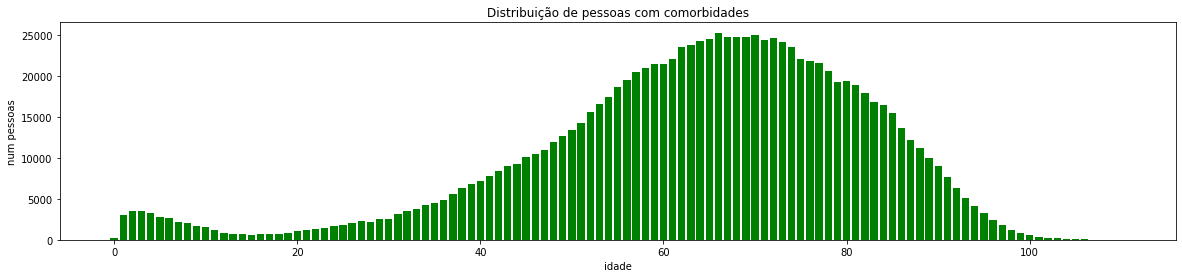

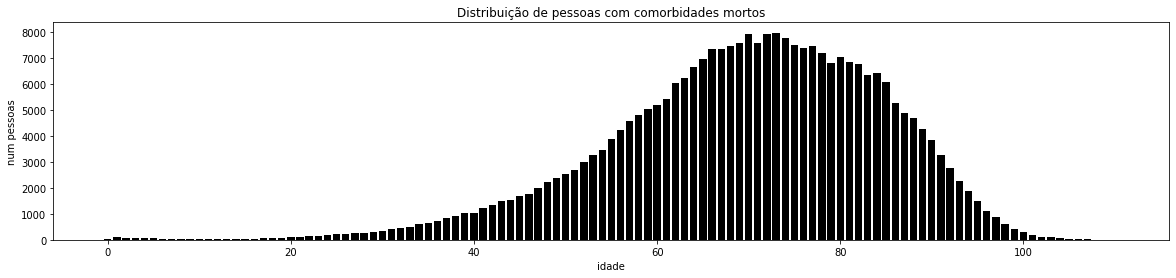

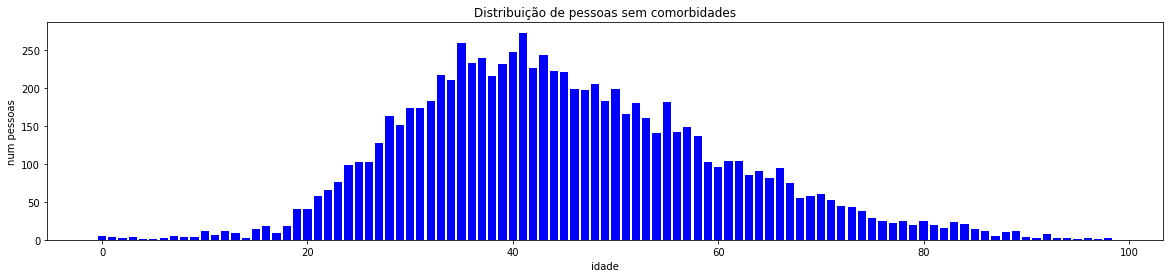

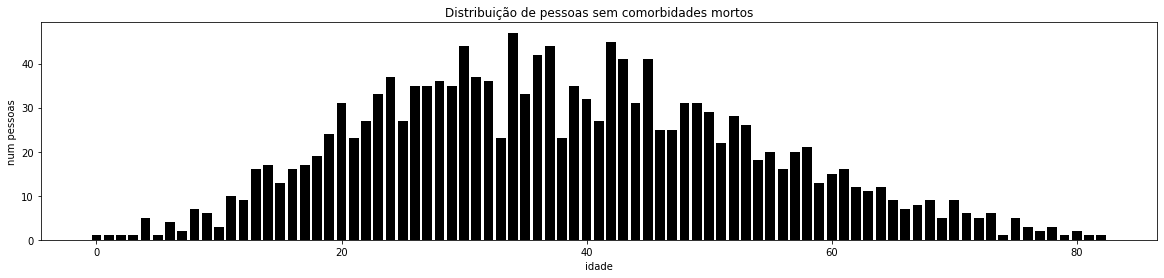

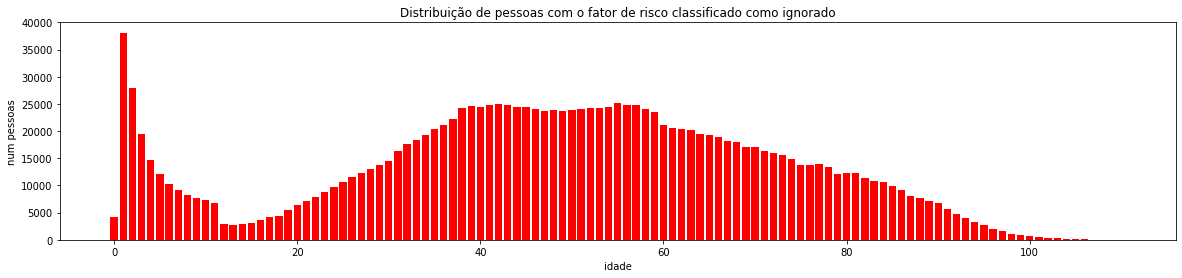

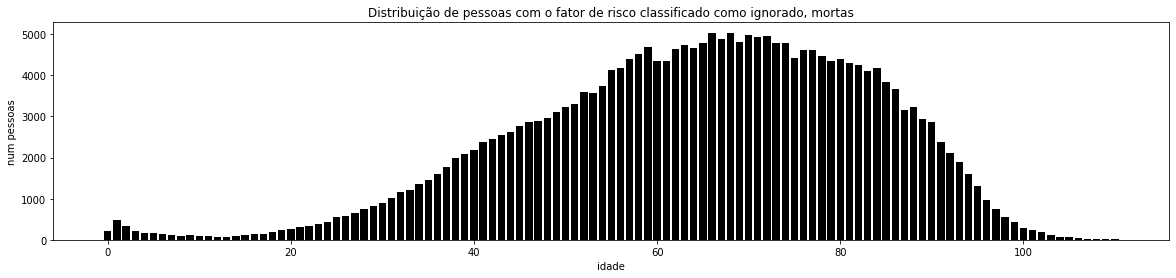

283620 mortos
27.42 % dos registros nessa base (pessoas com comorbidades) foram morreram
96.67 % mortos tem mais de 40 anos


In [63]:
df_risco = df[df["FATOR_RISC"] == 1][["DT_NOTIFIC","NU_IDADE_N",	"FATOR_RISC","EVOLUCAO"]]
df_sem_risco = df[df["FATOR_RISC"] == 2][["DT_NOTIFIC","NU_IDADE_N",	"FATOR_RISC","EVOLUCAO"]]
df_ignorado = df[df["FATOR_RISC"] == 9][["DT_NOTIFIC","NU_IDADE_N",	"FATOR_RISC","EVOLUCAO"]] # fiz isso para englobar o escopo de ignorados nos gráficos
                                                                                              # apagar comentário depois

df_sem_risco_por_idade  = df_sem_risco.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
df_risco_por_idade      = df_risco.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
df_ignorado_por_idade   = df_ignorado.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()

df_risco_mortos     = df_risco[df_risco["EVOLUCAO"] == 2]
df_sem_risco_mortos = df_sem_risco[df_sem_risco["EVOLUCAO"] == 2]
df_ignorados_mortos = df_ignorado[df_ignorado["EVOLUCAO"] == 2]

df_risco_mortos_por_idade     = df_risco_mortos.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
df_sem_risco_mortos_por_idade = df_sem_risco_mortos.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
df_ignorados_mortos_por_idade = df_ignorados_mortos.groupby(by= "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()

mostrar_graficos = True
if mostrar_graficos:
    grafico_barra(df_risco_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas com comorbidades", color = "g",show = False)
    grafico_barra(df_risco_mortos_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas com comorbidades mortos", color = "black")

    grafico_barra(df_sem_risco_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas sem comorbidades",show = False)
    grafico_barra(df_sem_risco_mortos_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas sem comorbidades mortos",color = "black")

    grafico_barra(df_ignorado_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas com o fator de risco classificado como ignorado", color = "red")
    grafico_barra(df_ignorados_mortos_por_idade.N_pessoas,xlabel = "idade",ylabel = "num pessoas", title = "Distribuição de pessoas com o fator de risco classificado como ignorado, mortas", color = "black")


N_mortos = df_risco_mortos.shape[0]
print(N_mortos,"mortos")
print(round(100*N_mortos/df_risco.shape[0],2),"% dos registros nessa base (pessoas com comorbidades) foram morreram")
print(
    round(
        100*df_risco_mortos_por_idade[40:].sum()[0]/N_mortos,
        2),
      "% mortos tem mais de 40 anos"
     )


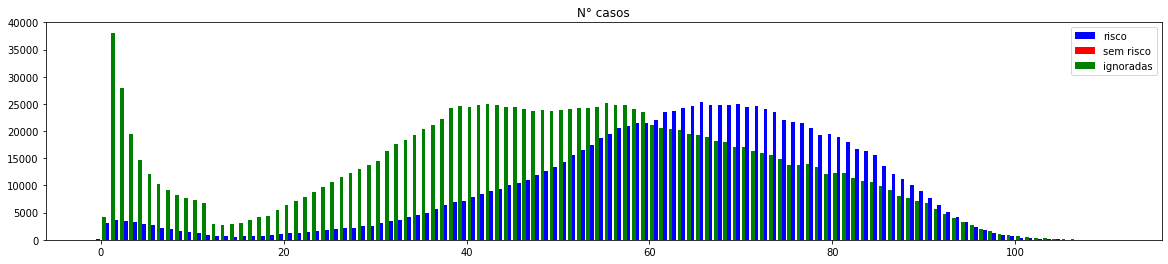

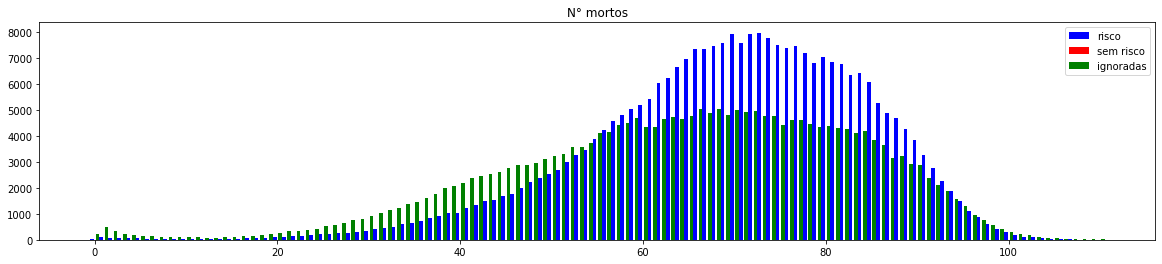

In [61]:
plt.figure(figsize=(20, 4)) 
plt.bar(np.arange(0,df_risco_por_idade.N_pessoas.size)-0.3, df_risco_por_idade.N_pessoas, color = 'b',
        label='risco',width=0.4)
plt.bar(np.arange(0,df_sem_risco_por_idade.N_pessoas.size)+0.3, df_sem_risco_por_idade.N_pessoas, color = 'r',   
        label='sem risco',width=0.4)
plt.bar(np.arange(0,df_ignorado_por_idade.N_pessoas.size)+0.3, df_ignorado_por_idade.N_pessoas, color = 'g',   
        label='ignoradas',width=0.4)

plt.title("N° casos")
plt.legend()
plt.show()


plt.figure(figsize=(20, 4)) 
plt.bar(np.arange(0,df_risco_mortos_por_idade.N_pessoas.size)-0.3, df_risco_mortos_por_idade.N_pessoas, color = 'b',
        label='risco',width=0.4)
plt.bar(np.arange(0,df_sem_risco_mortos_por_idade.N_pessoas.size)+0.3, df_sem_risco_mortos_por_idade.N_pessoas, color = 'r',   
        label='sem risco',width=0.4)
plt.bar(np.arange(0,df_ignorados_mortos_por_idade.N_pessoas.size)+0.3, df_ignorados_mortos_por_idade.N_pessoas, color = 'g',   
        label='ignoradas',width=0.4)

# colocar: risco ignorado

plt.title("N° mortos")
plt.legend()
plt.show()
  

# **Idade como um fator de risco**

Iremos usar a metrica por 10.000 pacientes para definir a taxa de mortos por idade,perceba pelo gráfico que o a taxa é maior que 1 acima de 60 anos, note que quanto mais velho maior o numero de casos e por fusão de um organismo mais debilitado temos uma taxa de mortes mais elevada. 

<BarContainer object of 111 artists>

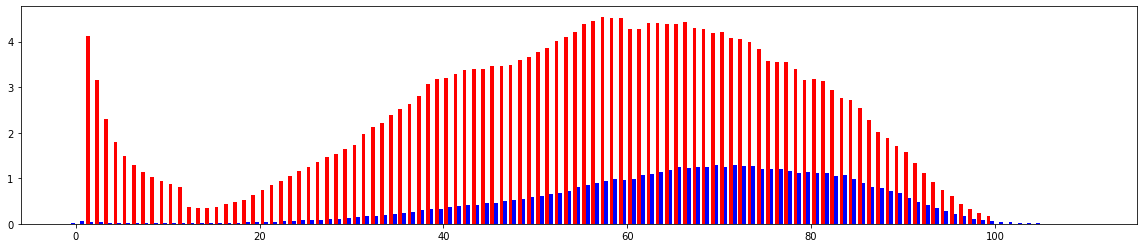

In [111]:
df_Total_De_Casos = (df_sem_risco_por_idade + df_risco_por_idade + df_ignorado_por_idade).div(10000)

df_risco_idade = df[df["EVOLUCAO"]== 2]
df_Risco_Idade_Agrupado = df_risco_idade.groupby(by = "NU_IDADE_N").count().div(10000).rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
#df_Risco_Idade_agrupado["EVOLUCAO"]

plt.figure(figsize=(20, 4)) 
plt.bar(np.arange(0,df_Total_De_Casos.N_pessoas.size)+0.3, df_Total_De_Casos.N_pessoas, color = 'r',   
        label='Casos por idade',width=0.4)
plt.bar(np.arange(0,df_Risco_Idade_agrupado.N_pessoas.size)-0.3, df_Risco_Idade_agrupado.N_pessoas, color = 'b',
        label='Mortes por idade',width=0.4)



#Apenas fazer download após limpeza

In [ ]:
#df.to_csv("base-all.csv", index = True)